# Imports

In [1]:
#%matplotlib widget
%matplotlib inline

import numpy as np
from random import randrange
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report,auc,r2_score,matthews_corrcoef
from catboost import CatBoostRegressor,CatBoostClassifier
from catboost.utils import get_roc_curve
import shap
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)
from sklearn import preprocessing
from catboost import Pool, cv
from scipy import stats
from sklearn import feature_selection as fs
from tabulate import tabulate
from scipy.optimize import curve_fit
from tqdm import tqdm
from numpy.random import RandomState
from scipy import stats
import pickle
import os
import ast
import seaborn as sns

In [2]:
import scipy.stats as stat
from scipy import stats
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

def print_coef(model, columns):
    """ Plot logistic regression model coefficients """ 
    coef = np.abs(pd.DataFrame(np.transpose(model.coef_), index = columns, columns = ['Coefficients']))
    coef = coef.sort_values(by=['Coefficients'], ascending=True)
    plt.figure(figsize = (6,18))
    plt.scatter(y = range(len(coef)), x = coef['Coefficients'])
    plt.yticks(range(len(coef)),coef.index, rotation = 'horizontal')
    plt.xlabel('LR coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
    plt.show()
    #return coef
    
def print_coef_std_int(coefs,intercept, columns_feat):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)
    
    quantile = p_values_null_coef(intercept)/100
    if quantile > 0.5:
        p_value_intercept = 1-quantile
    else:
        p_value_intercept = quantile


    p_values_coef = [p_value_intercept]
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1), xerr = np.append(intercept.std(),coef.std()),ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.axvline(x=0,color='black',alpha=0.5)
    plt.scatter(x = np.append(intercept.mean(),coef.mean().values), y = range(len(columns_feat)+1),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)+1),np.append(["AF"],columns_feat), rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    plt.show()
    
def print_coef_std(coefs, columns_feat,lim):
    """ Plot logistic regression model coefficients """ 
    coef = pd.DataFrame(coefs, columns = columns_feat)
    #coef = coef.sort_values(by=['Coefficients'], ascending=True)

    p_values_coef = []
    for i in range(len(columns_feat)):
        quantile = p_values_null_coef(coefs[:,i])/100
        if quantile > 0.5:
            p_values_coef.append(1-quantile)
        else:
            p_values_coef.append(quantile)
    
    plt.figure(figsize = (6,9))
    plt.errorbar(x = coef.mean().values, y = range(len(columns_feat)), xerr = [coef.mean().values-coef.quantile(0.05),coef.quantile(0.95)-coef.mean().values],ecolor=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color), fmt='none')
    plt.scatter(x = coef.mean().values, y = range(len(columns_feat)),color=np.where(np.array(p_values_coef)<0.05,significant_color,non_significant_color))
    plt.yticks(range(len(columns_feat)),columns_feat, rotation = 'horizontal')
    plt.xlabel('Coefficient')
    if present:
        ax = plt.gca()
        ax.patch.set_alpha(0)
        leg = ax.legend(handles=legend_elements)
        leg.get_frame().set_alpha(0)
        for text in leg.get_texts():
            text.set_color("white")
    else:
        plt.legend(handles=legend_elements)
    if lim>0:
        plt.xlim([-lim,lim])

    plt.show()
    
def p_values_lin_reg(model,X,y):
    model.fit(X,y)
    sse = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

    # compute the t-statistic for each feature
    t_test_val = model.coef_ / se
    # find the p-value for each feature
    p_value_lin = np.squeeze(2 * (1 - stat.t.cdf(np.abs(t_test_val), y.shape[0] - X.shape[1])))
    return p_value_lin

def p_values_null_coef(coefficients):
    #inverse of quantile
    return stats.percentileofscore(coefficients,0)

def p_values_arg_coef(coefficients,arg):
    #inverse of quantile
    return stats.percentileofscore(coefficients,arg)

def epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2)


def epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2)

def normalized_epsilon_PEHE(y_1,y_0,ITE):
    N = len(y_1)
    
    return 1/N * np.sum(((y_1-y_0)-(ITE))**2) * 1/(np.max(np.append(y_1,y_0))-np.min(np.append(y_1,y_0)))

def sqrt_epsilon_PEHE(y_1,y_0,ITE):
    return np.sqrt(epsilon_PEHE(y_1,y_0,ITE))


def sigmoid(x):
        return 1 / (1 + np.exp(-x))

# Prognostic vs Predictive
Based on paper: "On Discovering Treatment-Effect  Modifiers Using Virtual Twins  and Causal Forest ML in the Presence  of Prognostic Biomarkers"

## Simulation Datasets

In [3]:
ground_truth_pred_features = []
ground_truth_informative_features = []

def M1(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features =['x6', 'x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x6','x7']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 6] > 0).astype(int)*(x_features[:, 7] > 0).astype(int))+epsilon


def M2(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M3(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features =['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x19']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 19] > 0).astype(int))+epsilon 


def M4(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = []
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+epsilon


def M5(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x9', 'x10', 'x11', 'x12', 'x13', 'x14','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x9', 'x10', 'x11', 'x12', 'x13', 'x14']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 9]+x_features[:, 10]+x_features[:, 11]+x_features[:, 12]+x_features[:, 13]+x_features[:, 14])+epsilon


def M6(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x4','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*((x_features[:, 0] > 0).astype(int)+(x_features[:, 1] > 0).astype(int)+(x_features[:, 2] > 0).astype(int)+(x_features[:, 3] > 0).astype(int)+(x_features[:, 4] > 0).astype(int))+T*((x_features[:, 4] > 0).astype(int))+epsilon


def M7(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x19']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4]+x_features[:, 5]+x_features[:, 6]+x_features[:, 7]+x_features[:, 8]+x_features[:, 9])+T*((x_features[:, 19] > 0).astype(int))+epsilon


def M8(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4]+x_features[:, 5]+x_features[:, 6]+x_features[:, 7]+x_features[:, 8]+x_features[:, 9])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M9(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*np.sin(x_features[:, 0])+epsilon


def M10(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+10*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int))+epsilon


def M11(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])**3+T*((x_features[:, 0])**3)+epsilon


def M12(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 0])+epsilon


def M13(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x19','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x19']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*(x_features[:, 19])+epsilon


def M14(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x6','x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x6','x7']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+50*T*((x_features[:, 6] > 0).astype(int)*(x_features[:, 7] > 0).astype(int))+epsilon


def M15(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+50*T*((x_features[:, 0] > 0).astype(int))+epsilon


def M16(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x0', 'x1', 'x7','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x7']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+3*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 0] > 0).astype(int)+10*(x_features[:, 1] > 0).astype(int)+5*(x_features[:, 7] > 0).astype(int))+epsilon

def M17(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x5','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+10*(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])+T*((x_features[:, 5] > 0).astype(int))+epsilon


def M18(T, x_features, N, npRandomState, noise_std = 1):
    global ground_truth_pred_features, ground_truth_informative_features
    ground_truth_pred_features = ['x5','T']
    ground_truth_informative_features =['x0','x1','x2','x3','x4','x5']

    epsilon = npRandomState.normal(0, noise_std, N)
    return -1+(x_features[:, 0]+x_features[:, 1]+x_features[:, 2]+x_features[:, 3]+x_features[:, 4])**3+T*((x_features[:, 5])**3)+epsilon

def M_DGP(T, x_features, x_columns, N, npRandomState,d_pred,d_prog,thresh,w_pred,std_noise):
    global ground_truth_pred_features, ground_truth_informative_features, alpha_pred, alpha_prog

    epsilon = npRandomState.normal(0, std_noise, N)
    alpha_prog = npRandomState.uniform(-1,1,len(x_columns))
    alpha_pred = npRandomState.uniform(-1,1,len(x_columns))

    pred_above_threshold = np.where(np.abs(alpha_pred) > thresh)[0]
    prog_above_threshold = np.where(np.abs(alpha_prog) > thresh)[0]

    pred_features_alpha = np.sort(npRandomState.choice(pred_above_threshold,d_pred,replace=False))
    prog_features_alpha = np.sort(npRandomState.choice(prog_above_threshold,d_prog,replace=False))

    for i in range(len(x_columns)):
        if i not in pred_features_alpha:
            alpha_pred[i] = 0
        if i not in prog_features_alpha:
            alpha_prog[i] = 0

    ground_truth_pred_features = list(x_columns[pred_features_alpha])+['T']
    ground_truth_informative_features = list(set(list(x_columns[prog_features_alpha]) + list(x_columns[pred_features_alpha])))

    mu_prog = np.sum(alpha_prog * x_features,axis=1)
    mu_pred = np.sum(alpha_pred * x_features,axis=1)

    return mu_prog + T * w_pred * mu_pred + epsilon

def T0(x_features, N, npRandomState):
    return npRandomState.randint(0, 2, N)

def T1(x_features, N, npRandomState):
    logit_t1 = 0.1+0.5*x_features[:, 1]-0.25*(2+x_features[:, 2])

    return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


def T2(x_features, N, npRandomState):
    logit_t1 = 0.1+1.5*(1+x_features[:, 1])-0.25*x_features[:, 2]

    return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


# def T3(x_features, N, npRandomState):
#     logit_t1 = 0.1+1.5*x_features[:, 1]-0.25*x_features[:, 2]

#     return npRandomState.binomial(1, np.exp(logit_t1)/(1+np.exp(logit_t1)), N)


## Functions

In [4]:
def cumsum_kstest(A,B):
    A = np.sort(A)
    B = np.sort(B)
    na = A.shape[0]
    nb = B.shape[0]

    data_all = np.sort(np.concatenate([A,B]))

    cdf1 = np.searchsorted(A, data_all, side='right') / na

    cdf2 = np.searchsorted(B, data_all, side='right') / nb
    
    cddiffs = cdf1 - cdf2

    return data_all, cdf1, cdf2, cddiffs

def equisample_array_target(sample_array,reduce_array,N_bins = 5000):
    pseudo_array = np.arange(np.min(sample_array),np.max(sample_array),(np.max(sample_array) - np.min(sample_array))/N_bins)
    reduce_array_return = []

    for i in range(N_bins):
        sample_element = pseudo_array[i]
        idx = np.max(np.where(sample_array <= sample_element))
        new_element_reduce = reduce_array[idx]
        reduce_array_return.append(new_element_reduce)

    return np.array(reduce_array_return),pseudo_array

def s(X):
    return np.sqrt(1/len(X) * np.sum((X-np.mean(X))**2))

def compensated_welchs_ttest(A,B,R_A,R_B):

    t = (np.mean(A)-np.mean(B))/(np.sqrt((s(A) /np.sqrt(len(A)))**2+(s(B)/np.sqrt(len(B)))**2))

    t_random = (np.mean(R_A)-np.mean(R_B))/(np.sqrt((s(R_A) /np.sqrt(len(R_A)))**2+(s(R_B)/np.sqrt(len(R_B)))**2))

    df_A = len(A)-1
    df_B = len(B)-1

    deg_free = (s(A)**2+s(B)**2)**2 / (1/df_A * s(A)**4 + 1/df_B * s(B)**4)

    p_value_comp = (np.min([st.t.cdf(t - t_random,df=deg_free),1-st.t.cdf(t - t_random,df=deg_free)]))*2

    return t-t_random, p_value_comp

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(spearmanr(tmp[r], tmp[c])[1], 4)
    return pvalues



## DGP Datasets

In [5]:
dataset_string = "NEWS" #ACIC, TWINS, NEWS, TCGA

if dataset_string == "TWINS":
    x = pd.read_csv("Datasets/Twins_dataset.csv")

    DGP_df = x[['pldel', 'birattnd', 'brstate',
       'stoccfipb', 'mager8', 'ormoth', 'mrace', 'meduc6', 'dmar',
       'mplbir', 'mpre5', 'adequacy', 'orfath', 'frace', 'birmon',
       'gestat10', 'csex', 'anemia', 'cardiac', 'lung', 'diabetes',
       'herpes', 'hydra', 'hemo', 'chyper', 'phyper', 'eclamp',
       'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6', 'dlivord_min', 'dtotord_min', 
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']].copy(deep=True)

    DGP_df = DGP_df.fillna(0)

    DGP_df.to_csv("Twins_dataset",index=False)

elif dataset_string == "ACIC":
    DGP_df = pd.read_csv("Datasets/ACIC2016_dataset.csv")

elif dataset_string == "NEWS":
    dgp_file = open("Datasets/news_100_features_dataset.p", 'rb')
    DGP_array = pickle.load(dgp_file)
    DGP_df = pd.DataFrame(data=DGP_array,columns=["x"+str(i) for i in range(np.shape(DGP_array)[1])])
    DGP_array = None

elif dataset_string == "TCGA":
    dgp_file = open("Datasets/tcga_100_features_dataset.p", 'rb')
    DGP_array = pickle.load(dgp_file)
    DGP_array = DGP_array['rnaseq']
    DGP_df = pd.DataFrame(data=DGP_array,columns=["x"+str(i) for i in range(np.shape(DGP_array)[1])])
    DGP_array = None


threshold_value = 0.02
keep_cols = []

for col in DGP_df.columns.values:
    percentage_diff_values = DGP_df[col].value_counts().reset_index(drop=True)[1:].sum() / len(DGP_df)
    if percentage_diff_values >= threshold_value:
        keep_cols.append(col)

DGP_df = DGP_df[keep_cols]

i = 0
for col in keep_cols:
    DGP_df = DGP_df.rename(columns={col:"x"+str(i)})
    i += 1 

DGP_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,0.374601,0.303594,0.202278,0.387721,0.171826,0.314659,0.398340,0.197056,0.285733,0.215948,0.500027,0.466278,0.301435,0.502475,0.232182,0.422610,0.362295,0.513785,0.536267,0.317531,0.284488,0.274228,0.413619,0.576815,0.458812,0.727100,0.379272,0.377066,0.222521,0.343260,0.453741,0.467833,0.460294,0.317654,0.424908,0.378299,0.492011,0.405834,0.272957,0.471709,0.436885,0.534022,0.343161,0.419781,0.281688,0.487031,0.584721,0.374886,0.388136,0.316403,0.340359,0.356651,0.389700,0.196976,0.493396,0.468541,0.421133,0.509623,0.540472,0.418029,0.426033,0.515089,0.465581,0.421294,0.420402,0.438664,0.393198,0.415956,0.452135,0.412473,0.314468,0.378623,0.458105,0.385540,0.421364,0.423236,0.422950,0.326758,0.494737,0.428240,0.406495,0.426190,0.487197,0.483225,0.350320,0.494670,0.468780,0.383108,0.296648,0.493076,0.294601,0.195567,0.429201,0.349105,0.363532,0.236476,0.193442,0.168369,0.373844,0.480011
1,0.382396,0.337081,0.284364,0.411720,0.165472,0.307419,0.468726,0.268527,0.308672,0.280210,0.464298,0.476204,0.321565,0.507985,0.267631,0.343652,0.272242,0.468232,0.534093,0.289327,0.345871,0.312183,0.468330,0.494621,0.358519,0.362634,0.342739,0.259772,0.369911,0.434049,0.534049,0.362043,0.441057,0.296533,0.410161,0.418953,0.445818,0.455290,0.335520,0.459910,0.459340,0.526854,0.353720,0.467245,0.259344,0.507541,0.459350,0.474187,0.412764,0.245073,0.221372,0.305178,0.413199,0.239434,0.470290,0.488245,0.331116,0.334482,0.500861,0.428032,0.286999,0.271745,0.468415,0.438657,0.499077,0.392740,0.311553,0.347105,0.508440,0.361758,0.265757,0.387452,0.381808,0.341163,0.505841,0.400444,0.321721,0.404518,0.498721,0.482210,0.370190,0.375358,0.398446,0.388574,0.404141,0.493925,0.454098,0.475604,0.217891,0.450696,0.303985,0.193445,0.395927,0.390338,0.402807,0.258737,0.235748,0.161383,0.241275,0.454156
2,0.272323,0.420122,0.356422,0.330663,0.132794,0.384198,0.455654,0.259581,0.290792,0.229859,0.413742,0.427869,0.320757,0.461711,0.241077,0.384032,0.482045,0.491426,0.560102,0.325470,0.428062,0.313178,0.458003,0.498547,0.311679,0.356761,0.382354,0.272836,0.277593,0.398767,0.532025,0.526547,0.403831,0.248551,0.393355,0.361181,0.438837,0.373874,0.333747,0.464011,0.437593,0.524109,0.437116,0.340064,0.268288,0.519520,0.555256,0.384115,0.396321,0.298159,0.306600,0.308913,0.305874,0.245138,0.485630,0.508498,0.417308,0.304868,0.496821,0.358295,0.383754,0.459501,0.413727,0.349429,0.460374,0.407904,0.377468,0.366300,0.516835,0.321317,0.259145,0.350642,0.457900,0.362208,0.448305,0.429207,0.409191,0.363451,0.565308,0.481070,0.429776,0.410197,0.419121,0.502532,0.383611,0.403442,0.450990,0.419805,0.295328,0.410815,0.348548,0.221810,0.411630,0.303289,0.375818,0.244134,0.191749,0.162091,0.417896,0.514740
3,0.520232,0.309134,0.290693,0.350780,0.141833,0.371167,0.468597,0.278473,0.308869,0.223316,0.461685,0.459228,0.289423,0.390387,0.232231,0.326756,0.314677,0.486056,0.475727,0.257455,0.330830,0.340159,0.400916,0.419097,0.367304,0.375804,0.393314,0.296146,0.309351,0.436866,0.511806,0.410266,0.393711,0.322004,0.440615,0.331410,0.401567,0.320435,0.257950,0.416047,0.562044,0.419190,0.359817,0.454972,0.282107,0.534157,0.534692,0.396775,0.462140,0.297778,0.214011,0.300895,0.390454,0.212457,0.472691,0.470294,0.413924,0.418342,0.383134,0.438296,0.342034,0.364739,0.454817,0.529399,0.485803,0.465670,0.409198,0.465947,0.492596,0.375032,0.255166,0.422199,0.414092,0.362084,0.402846,0.441699,0.346691,0.356363,0.592425,0.464507,0.419588,0.439780,0.459911,0.400439,0.445635,0.516302,0.597866,0.432448,0.229299,0.318555,0.249799,0.157971,0.489270,0.349935,0.414093,0.284162,0.210985,0.172442,0.368559,0.457252
4

## DataFrame results definition

In [6]:
semi_synthetic_bool = True

if semi_synthetic_bool:
    causalteshap_semi_synthetic_columns = [
                    "random_seed",
                    "w_pred",
                    "N_prog",
                    "N_pred",
                    "alpha",
                    "noise",
                    "True_pred",
                    "Found_pred",
                    "Found_candidate_pred",
                    "True_pred_corr",
                    "Found_pred_corr",
                    "Found_candidate_corr",
    ]

    causalteshap_synthetic_df = pd.DataFrame(None,columns=causalteshap_semi_synthetic_columns)

else:

    causalteshap_synthetic_columns = [
                    "synthetic_N",
                    "random_seed",
                    "CASE",
                    "CONF_CASE",
                    "alpha",
                    "noise",
                    "True_pred",
                    "Found_pred",
                    "Found_candidate_pred",
    ]

    causalteshap_synthetic_df = pd.DataFrame(None,columns=causalteshap_synthetic_columns)


## Experiment loop

### Experiment loop playground

In [7]:
%load_ext autoreload
%autoreload 2

In [146]:
from causalteshap.causalteshap import CausalteShap
from lightgbm import LGBMRegressor

DGP_pred = 3
w_pred = 1.0 #0.5
DGP_prog = 10
p = len(DGP_df.columns.values) 
N = len(DGP_df) 
noise_level = 0.07 #10# 0.125#15
# noise_level = 0.0000000005 #10# 0.125#15

columns_list = []
for l in range(p):
    columns_list.append("x"+str(l))

npRandomState = RandomState(1)
npRandomState_or = RandomState(42)

x_features = DGP_df.copy(deep=True).values

treatment_assignment = T0(x_features,N,npRandomState)

npRandomState_or = RandomState(42)
y = M_DGP(treatment_assignment,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
npRandomState_or = RandomState(42)
y_0 = M_DGP(np.zeros(N),x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
npRandomState_or = RandomState(42)
y_1 = M_DGP(np.zeros(N)+1,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)


X_df = pd.DataFrame(data=x_features,columns=columns_list)
X_df = X_df.reset_index(drop=True)
X_df["y"]=y
X_df["y_0"]=y_0
X_df["y_1"]=y_1
X_df["T"]=treatment_assignment

selected_columns_list = list(np.sort(ground_truth_informative_features))

# selected_columns_list.append("x3")
# selected_columns_list.append("x4")
# selected_columns_list.append("x5")
# selected_columns_list.append("x6") 
# selected_columns_list.append("x7")

S_learner = CatBoostRegressor(iterations=1000,verbose=0,use_best_model=True,random_seed=5,cat_features=["T"])
# S_learner = LGBMRegressor(n_estimators=750)#(iterations=1000,verbose=0,use_best_model=True,random_seed=5)

causalteshap_class = CausalteShap(model=S_learner,verbose=False,significance_factor=0.02,val_size=0.2,meta_learner="S",candidate_convergence=False)
causalteshap_class.fit(X=X_df[selected_columns_list],T=X_df["T"],y=X_df["y"])

print(ground_truth_pred_features)
print(causalteshap_class.get_predictive())
causalteshap_class.get_analysis_df().reset_index()

['x52', 'x57', 'x60', 'T']
['x52', 'x57', 'x60', 'x71']


,index,ks-statistic,ttest,fligner,T1-T0,abs(T1)-abs(T0),predictive,candidate
0,x52,0.000000,0.351,0.000,-0.002768,0.104219,1.0,1.0
1,x57,0.000000,0.646,0.000,0.001482,0.099860,1.0,1.0
2,x60,0.022355,0.856,0.000,-0.000508,0.074311,1.0,1.0
3,x71,0.022355,0.948,0.009,0.000204,0.009022,1.0,1.0
4,x12,1.520146,0.994,0.008,-0.000030,0.009456,0.0,1.0
5,x25,0.134131,0.997,0.938,0.000012,0.000633,0.0,0.0
6,x35,0.044710,0.940,0.040,0.000251,0.007606,0.0,0.0
7,x48,0.022355,0.992,0.060,0.000042,-0.007838,0.0,0.0
8,x61,0.067065,0.956,0.212,0.000270,0.007994,0.0,0.0
9,x72,1.073044,0.989,0.228,-0.000057,0.002760,0.0,0.0


### Actual Experiment loop

In [419]:
from catboost import CatBoostRegressor
# from xgboost import XGBClassifier,XGBRegressor
# from lightgbm import LGBMClassifier,LGBMRegressor
import scipy.stats as st
# from powershap import PowerShap
# import statsmodels.stats.power as stp

prediction_array = np.array([])
candidate_array = np.array([])
true_array = np.array([])

S_learner_bool = True
second_correlation = False #True
print_bool_causalteshap = False
save_df = False # True

if semi_synthetic_bool:
    DGP_pred_choices = [0.10]#[0.03,0.125,0.28,0.5]#[1,4,9,16]
    DGP_prog_choices = [0.40]#[0.10,0.25,0.40,0.65] #3,8,13,21
    w_pred_choices = [0.1]#[0.01,0.1,0.5,1.0]

    synthetic_N_cases = [5000]
    treatment_loop_cases = [T0]
    outcome_loop_cases = [M1]

    synthetic_results_path = "results/causalteshap_semi_synthetic_results_"+dataset_string+".csv"
    # synthetic_results_path = "results/causalteshap_semi_synthetic_results_noise_"+dataset_string+".csv"
    max_seed_loop = 5
    noise_levels = [0.00000005]#[0.05]#, 0.01, 0.1, 1.0, 5, 10.0]

else:
    DGP_pred_choices = [1]
    DGP_prog_choices = [1]
    w_pred_choices = [1.0] 

    synthetic_N_cases = [5000]#[100,250,500,1000,2500,5000,10000]
    treatment_loop_cases = [T0,T1,T2]
    outcome_loop_cases = [M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14,M15,M16,M17,M18] 

    synthetic_results_path = "results/causalteshap_synthetic_results.csv"
    noise_levels = [1.0]#[0.001,0.01,0.1,0.5,1.0,2.5,5,10]
    max_seed_loop = 1#3 #10 #10


alpha_possible = [0.02]#np.arange(0.01,0.20,0.01)

for synthetic_N in synthetic_N_cases:
    for w_pred in w_pred_choices:
        for noise_level in noise_levels:
            prediction_array_all = np.array([])
            candidate_array_all = np.array([])
            true_array_all = np.array([])

            for p_prog in DGP_prog_choices:
                for p_pred in DGP_pred_choices:
                    N = len(DGP_df) if semi_synthetic_bool else synthetic_N #5000 #5000 # 5000 or 800
                    p = len(DGP_df.columns.values) if semi_synthetic_bool else 20 #number of candidate biomarkers

                    DGP_pred = int(np.ceil(p_pred*len(DGP_df.columns.values)))
                    DGP_prog = int(np.ceil(p_prog*len(DGP_df.columns.values)))

                    print("")
                    if semi_synthetic_bool:
                        print("N PROG: "+str(DGP_prog))
                        print("N PRED: "+str(DGP_pred))
                        print("w_pred = "+str(w_pred))
                        print("Noise level (std) = "+str(noise_level))
                        
                    else:
                        print("Sythetic N = "+str(synthetic_N))
                        print("Noise level (std) = "+str(noise_level))

                    columns_list = []
                    for l in range(p):
                        columns_list.append("x"+str(l))

                    for seed_n in range(max_seed_loop):
                        
                        # print("")
                        seed = 42 + seed_n #42
                        # print("")
                        print("seed iteration: " +str(seed_n)+"/"+str(max_seed_loop))

                        print_idx = 0

                        for treatment_numb in treatment_loop_cases:
                            for m_function in outcome_loop_cases: 

                                if semi_synthetic_bool:
                                    case = M_DGP
                                else:
                                    case = m_function #9
                                    if print_bool_causalteshap:
                                        print(10*"="+" CONF = "+str(treatment_numb.__name__)+" "+10*"="+" CASE = "+str(m_function.__name__)+" "+10*"=")

                                treatment_case = treatment_numb#T0#T1

                                npRandomState = RandomState(1)
                                npRandomState_or = RandomState(seed)

                                normal_mean = 0 #npRandomState_or.uniform(-1,1,1) #1#0 #np.pi
                                normal_std = 1 #1

                                if semi_synthetic_bool:
                                    x_features = DGP_df.copy(deep=True).values
                                else:
                                    x_features = np.array([])
                                    for j in range(p):
                                        if len(x_features)>0:
                                            x_features = np.vstack([x_features,npRandomState_or.normal(normal_mean,normal_std,N)])
                                        else:
                                            x_features = npRandomState_or.normal(normal_mean,normal_std,N)

                                    x_features = np.transpose(x_features)

                                treatment_assignment = treatment_case(x_features,N,npRandomState)

                                if semi_synthetic_bool:
                                    npRandomState_or = RandomState(seed)
                                    y = case(treatment_assignment,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_0 = case(np.zeros(N),x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_1 = case(np.zeros(N)+1,x_features,DGP_df.columns.values,N,npRandomState_or, DGP_pred, DGP_prog, 0.1, w_pred, noise_level)
                                else:
                                    npRandomState_or = RandomState(seed)
                                    y = case(treatment_assignment,x_features,N,npRandomState_or,noise_std = noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_0 = case(np.zeros(N),x_features,N,npRandomState_or,noise_std = noise_level)
                                    npRandomState_or = RandomState(seed)
                                    y_1 = case(np.zeros(N)+1,x_features,N,npRandomState_or,noise_std = noise_level)

                                X_df = pd.DataFrame(data=x_features,columns=columns_list)
                                X_df = X_df.reset_index(drop=True)
                                X_df["y"]=y
                                X_df["y_0"]=y_0
                                X_df["y_1"]=y_1
                                X_df["T"]=treatment_assignment

                                if print_bool_causalteshap:
                                    print("ATE = "+str(np.round(np.mean(np.abs(y_1 - y_0))/np.mean(np.abs(y_0))*100,3))+ " %")

                                selected_columns_list = list(np.sort(ground_truth_informative_features))

                                ITE_mean_abs_array = []
                                causal_label = "T"

                                X_causal_ITE = X_df.copy(deep=True)
                                median_arr_list = []
                                subtr_list = []
                                pred_matrix_list = []
                                prog_matrix_list = []
                                T1_matrix_list = []

                                npRandomState_ran_feature = RandomState(45)

                                # random_mean_feature = X_causal_ITE[selected_columns_list].mean(axis=1).sample(len(X_causal_ITE))
                                # X_causal_ITE['random_uniform'] = random_mean_feature

                                X_causal_ITE['random_uniform'] = 0
                                X_causal_ITE.loc[:,"random_uniform"] = npRandomState_ran_feature.uniform(-1,1,len(X_causal_ITE))
                                # X_causal_ITE.loc[:,"random_uniform"] = npRandomState_ran_feature.normal(0,1,len(X_causal_ITE))
                                
                                X_causal_ITE_train, X_causal_ITE_test = train_test_split(X_causal_ITE,test_size=0.2,random_state=42)

                                if S_learner_bool:
                                    feature_set_pred = selected_columns_list+[causal_label]+['random_uniform']
                                else:
                                    feature_set_pred = selected_columns_list+['random_uniform']

                                if S_learner_bool:
                                    predictive_CB = CatBoostRegressor(iterations=1000, verbose=0,use_best_model=True,cat_features="T")
                                    predictive_CB.fit(X_causal_ITE_train[feature_set_pred],X_causal_ITE_train['y'].values,eval_set=(X_causal_ITE_test[feature_set_pred],X_causal_ITE_test['y'].values))
                                
                                else:
                                    CB_T0 = CatBoostRegressor(iterations=500, verbose=0,use_best_model=True)

                                    CB_T0.fit(
                                        X_causal_ITE_train[X_causal_ITE_train[causal_label]==0][feature_set_pred],
                                        X_causal_ITE_train[X_causal_ITE_train[causal_label]==0]['y'].values,
                                        eval_set=(X_causal_ITE_test[X_causal_ITE_test[causal_label]==0][feature_set_pred],X_causal_ITE_test[X_causal_ITE_test[causal_label]==0]['y'].values)
                                            )

                                    CB_T1 = CatBoostRegressor(iterations=500, verbose=0,use_best_model=True)

                                    CB_T1.fit(
                                        X_causal_ITE_train[X_causal_ITE_train[causal_label]==1][feature_set_pred],
                                        X_causal_ITE_train[X_causal_ITE_train[causal_label]==1]['y'].values,
                                        eval_set=(X_causal_ITE_test[X_causal_ITE_test[causal_label]==1][feature_set_pred],X_causal_ITE_test[X_causal_ITE_test[causal_label]==1]['y'].values)
                                            )

                                X_causal_ITE_do0 = X_causal_ITE_test.copy(deep=True)
                                X_causal_ITE_do0.loc[:,causal_label] = 0
                                # X_causal_ITE_do0.loc[:,"random_uniform"] = npRandomState_ran_feature.uniform(-1,1,len(X_causal_ITE_do0))

                                X_causal_ITE_do1 = X_causal_ITE_test.copy(deep=True)
                                X_causal_ITE_do1.loc[:,causal_label] = 1
                                # X_causal_ITE_do1.loc[:,"random_uniform"] = npRandomState_ran_feature.uniform(-1,1,len(X_causal_ITE_do1))

                                if S_learner_bool:
                                    explainer = shap.TreeExplainer(model=predictive_CB)
                                else:
                                    explainer = shap.TreeExplainer(model=CB_T1)
                                shap_values_do1 = explainer.shap_values(X_causal_ITE_do1[feature_set_pred])

                                if S_learner_bool:
                                    explainer = shap.TreeExplainer(model=predictive_CB)
                                else:
                                    explainer = shap.TreeExplainer(model=CB_T0)
                                shap_values_do0 = explainer.shap_values(X_causal_ITE_do0[feature_set_pred])

                                shap_values_predictive = np.abs(shap_values_do1) - np.abs(shap_values_do0)
                                shap_values_prognostic = shap_values_do0
                                
                                # if i == 0:
                                pred_matrix_list = shap_values_predictive
                                prog_matrix_list = shap_values_prognostic
                                T1_matrix_list = shap_values_do1
                                # else:
                                    # pred_matrix_list = np.vstack([pred_matrix_list,shap_values_predictive])
                                    # prog_matrix_list = np.vstack([prog_matrix_list,shap_values_prognostic])
                                    # T1_matrix_list = np.vstack([T1_matrix_list,shap_values_do1]) 

                                predictive_vars = []
                                candidate_vars = []

                                for significance_factor in alpha_possible:

                                    true_array = np.array([])
                                    prediction_array = np.array([])
                                    candidate_array = np.array([])

                                    # print("alpha = "+str(significance_factor))

                                    for i in range(len(feature_set_pred)-2):
                                        if print_bool_causalteshap:
                                            print("Feature = "+feature_set_pred[i])

                                        # p_value_is_not_greater = np.round(
                                        #     st.kstest(  
                                        #         np.abs(pred_matrix_list[:,i]),#-np.abs(pred_matrix_list[:-1,-1]),
                                        #         np.abs(pred_matrix_list[:,-1]),#-np.abs(pred_matrix_list[:-1,-1]),
                                        #         alternative='greater'
                                        #     )[1],3
                                        # )

                                        data_all, cdf1, cdf2, cddiffs = cumsum_kstest(
                                            np.abs(pred_matrix_list[:,i]),#-np.abs(pred_matrix_list[:-1,-1]),
                                            np.abs(pred_matrix_list[:,-1]),#-np.abs(pred_matrix_list[:-1,-1]),
                                        )

                                        calculated_D_ks = np.max(np.abs((cdf1 - cdf2)[cdf1 - cdf2 >= 0 ]))
                                        n_samples = len(np.abs(pred_matrix_list[:-1,i]))
                                        comp_D_ks = np.sqrt(n_samples)*calculated_D_ks
                                        condition = np.sqrt(-0.5*np.log(1-significance_factor))

                                        # p_value_ttest = np.round(
                                        #     st.ttest_ind(
                                        #         np.abs(T1_matrix_list[:,i]),
                                        #         np.abs(prog_matrix_list[:,i]),
                                        #         alternative='two-sided',
                                        #         equal_var = False
                                        #     )[1],3
                                        #     )
                                        
                                        p_value_ttest = np.round(
                                            st.ttest_ind(
                                                T1_matrix_list[:, i],
                                                prog_matrix_list[:, i],
                                                alternative='two-sided',
                                                equal_var=True
                                            )[1], 3) 
                                        p_value_fligner = np.round(
                                            st.fligner(
                                                T1_matrix_list[:, i],
                                                prog_matrix_list[:, i],
                                            )[1], 3
                                        )
                                        # ttest_res = st.ttest_ind(
                                        #         np.abs(T1_matrix_list[:,i]),
                                        #         np.abs(prog_matrix_list[:,i]),
                                        #         alternative='two-sided',
                                        #         equal_var = False
                                        #     )

                                        if feature_set_pred[i] == causal_label:
                                            if comp_D_ks < condition:
                                                true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                predictive_vars.append(feature_set_pred[i])
                                                prediction_array = np.append(prediction_array,np.array([1]))
                                                candidate_array = np.append(candidate_array,np.array([1]))
                                            else:
                                                true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                prediction_array = np.append(prediction_array,np.array([0]))
                                                candidate_array = np.append(candidate_array,np.array([0]))
                                        else:
                                            if (
                                                comp_D_ks < condition
                                                and (p_value_ttest <= significance_factor or p_value_fligner <= significance_factor)
                                                ):
                                                predictive_vars.append(feature_set_pred[i])

                                                if feature_set_pred[i] not in ground_truth_pred_features:
                                                    if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False)) > 1:
                                                        second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False).iloc[1]
                                                        if not second_max_abs_correlation_value > 0.1:
                                                            true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                            candidate_array = np.append(candidate_array,np.array([1]))
                                                            prediction_array = np.append(prediction_array,np.array([1]))
                                                        
                                                    else:
                                                        true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                        candidate_array = np.append(candidate_array,np.array([1]))
                                                        prediction_array = np.append(prediction_array,np.array([1]))

                                                else:
                                                    true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                    candidate_array = np.append(candidate_array,np.array([1]))
                                                    prediction_array = np.append(prediction_array,np.array([1]))

                                            elif (p_value_ttest <= significance_factor or p_value_fligner <= significance_factor):

                                                candidate_vars.append(feature_set_pred[i])

                                                if feature_set_pred[i] not in ground_truth_pred_features:
                                                    if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False)) > 1:
                                                    # if second_correlation and np.sum(calculate_pvalues(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]])[feature_set_pred[i]]<0.02)>1:
                                                        second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[feature_set_pred[i]]].corr("spearman")[feature_set_pred[i]]).sort_values(ascending=False).iloc[1]
                                                        if not second_max_abs_correlation_value > 0.1:
                                                            true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                            candidate_array = np.append(candidate_array,np.array([1]))
                                                            prediction_array = np.append(prediction_array,np.array([0]))

                                                    else:
                                                        true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                        candidate_array = np.append(candidate_array,np.array([1]))
                                                        prediction_array = np.append(prediction_array,np.array([0]))
                                                else:
                                                    true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                    candidate_array = np.append(candidate_array,np.array([1]))
                                                    prediction_array = np.append(prediction_array,np.array([0]))
                                                
                                            else:
                                                true_array = np.append(true_array, [1 if feature_set_pred[i] in ground_truth_pred_features else 0])

                                                prediction_array = np.append(prediction_array,np.array([0]))
                                                candidate_array = np.append(candidate_array,np.array([0]))

                                            if semi_synthetic_bool:
                                                weight_i_feature = w_pred*alpha_pred[int(feature_set_pred[i].replace('x',''))]
                                                true_mean_effect = np.round(np.mean(weight_i_feature * X_causal_ITE_test[feature_set_pred[i]]) / np.mean(np.abs(y_0))*100,5)
                                                true_std_effect = np.round(np.std(weight_i_feature * X_causal_ITE_test[feature_set_pred[i]]) / np.mean(np.abs(y_0))*100,5)

                                                if print_bool_causalteshap:
                                                    print("Mean (std) true effect of feature: "+str(true_mean_effect)+" % (+-"+str(true_std_effect)+")")

                                        if print_bool_causalteshap:
                                            print("KS greater statistic (< condition): "+str(np.round(comp_D_ks,3))+ " > "+str(np.round(condition,3))+" ?")
                                            # print("p-value (ks greater): "+str(p_value_is_not_greater))
                                            print("p-value (current ttest): "+str(p_value_ttest))
                                            # print("p-value (normal ttest): "+str(ttest_res.pvalue))

                                            print(10*"-")

                                    prediction_array_all = np.append(prediction_array_all,prediction_array) 
                                    candidate_array_all = np.append(candidate_array_all,candidate_array) 
                                    true_array_all = np.append(true_array_all,true_array) 

                                    if print_bool_causalteshap:
                                        print("Found predictive vars: " +str(predictive_vars))
                                        print("Found candidate vars: "+str(candidate_vars))
                                    if S_learner_bool:
                                        if print_bool_causalteshap:
                                            print("True predictive vars: " +str(ground_truth_pred_features))
                                    else:
                                        if 'T' in ground_truth_pred_features:
                                            ground_truth_pred_features_df = ground_truth_pred_features[:-1]
                                            if print_bool_causalteshap:
                                                print("True predictive vars: " +str(ground_truth_pred_features[:-1]))
                                        else:
                                            ground_truth_pred_features_df = ground_truth_pred_features
                                            if print_bool_causalteshap:
                                                print("True predictive vars: " +str(ground_truth_pred_features))

                                    false_positive_predictive_features = []
                                    for el in predictive_vars:
                                        if el not in ground_truth_pred_features:
                                            false_positive_predictive_features.append(el)

                                    false_positive_candidate_features = []
                                    for el in candidate_vars:
                                        if el not in ground_truth_pred_features:
                                            false_positive_candidate_features.append(el)

                                    if print_bool_causalteshap:
                                        print("false positive predictive vars: "+str(false_positive_predictive_features))
                                        print("false positive candidate vars: "+str(false_positive_candidate_features))

                                        print(30*"=")
                                        print("PREDICTIVE VARS FALSE POSITIVES")
                                        print(30*"=")
                                        for el in false_positive_predictive_features:
                                            if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False)) > 1:
                                                second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
                                                second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
                                                print("FP feature : "+str(el))
                                                print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
                                                print(15*"-")

                                        print("")
                                        print(30*"=")
                                        print("CANDIDATE VARS FALSE POSITIVES")
                                        print(30*"=")
                                        for el in false_positive_candidate_features:
                                            if second_correlation and len(np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False)) > 1:
                                                second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
                                                second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
                                                print("FP feature : "+str(el))
                                                print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
                                                print(15*"-")

                                    if save_df:
                                        if semi_synthetic_bool:

                                            # save_df_synthetic_df = pd.DataFrame(data=[[seed_n,w_pred,DGP_prog,DGP_pred,significance_factor,
                                            # [1 if feature_set_pred[l] in ground_truth_pred_features else 0 for l in range(len(feature_set_pred)-2)],
                                            # [1 if feature_set_pred[l] in predictive_vars else 0 for l in range(len(feature_set_pred)-2)],
                                            # [1 if feature_set_pred[l] in candidate_vars else 0 for l in range(len(feature_set_pred)-2)]]],columns=causalteshap_semi_synthetic_columns)

                                            save_df_synthetic_df = pd.DataFrame(data=[[seed_n,w_pred,DGP_prog,DGP_pred,significance_factor,noise_level,
                                            [1 if feature_set_pred[l] in ground_truth_pred_features else 0 for l in range(len(feature_set_pred)-2)],
                                            [1 if feature_set_pred[l] in predictive_vars else 0 for l in range(len(feature_set_pred)-2)],
                                            [1 if feature_set_pred[l] in candidate_vars else 0 for l in range(len(feature_set_pred)-2)],
                                            list(true_array),list(prediction_array),list(candidate_array)]],columns=causalteshap_semi_synthetic_columns)

                                            causalteshap_synthetic_df = pd.concat([causalteshap_synthetic_df,save_df_synthetic_df])
                                            
                                            if os.path.exists(synthetic_results_path):
                                                save_df_synthetic_df.to_csv(synthetic_results_path,mode='a',index=False, header=False)
                                            else:
                                                save_df_synthetic_df.to_csv(synthetic_results_path,index=False)

                                        else:
                                            save_df_synthetic_df = pd.DataFrame(data=[[synthetic_N,seed_n,m_function.__name__,treatment_numb.__name__,significance_factor,noise_level,
                                            [1 if feature_set_pred[l] in ground_truth_pred_features else 0 for l in range(len(feature_set_pred)-2)],
                                            [1 if feature_set_pred[l] in predictive_vars else 0 for l in range(len(feature_set_pred)-2)],
                                            [1 if feature_set_pred[l] in candidate_vars else 0 for l in range(len(feature_set_pred)-2)]]],columns=causalteshap_synthetic_columns)

                                            causalteshap_synthetic_df = pd.concat([causalteshap_synthetic_df,save_df_synthetic_df])
                                            
                                            if os.path.exists(synthetic_results_path):
                                                save_df_synthetic_df.to_csv(synthetic_results_path,mode='a',index=False, header=False)
                                            else:
                                                save_df_synthetic_df.to_csv(synthetic_results_path,index=False)

                                    print_idx = print_idx+1

            print("Predictive vs True")
            print(classification_report(true_array_all,prediction_array_all,zero_division=True))

            print("Candidates vs True")
            print(classification_report(true_array_all,candidate_array_all,zero_division=True))


# print("Predictive vs True")
# print(classification_report(true_array,prediction_array))

# print("Candidates vs True")
# print(classification_report(true_array,candidate_array))


N PROG: 40
N PRED: 10
w_pred = 0.1
Noise level (std) = 5e-08
seed iteration: 0/5
seed iteration: 1/5
seed iteration: 2/5
seed iteration: 3/5
seed iteration: 4/5
Predictive vs True
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90       184
         1.0       0.91      0.20      0.33        50

    accuracy                           0.82       234
   macro avg       0.86      0.60      0.61       234
weighted avg       0.84      0.82      0.78       234

Candidates vs True
              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       184
         1.0       0.93      0.28      0.43        50

    accuracy                           0.84       234
   macro avg       0.88      0.64      0.67       234
weighted avg       0.86      0.84      0.81       234



## Experiment processing

In [ ]:
process_correlation = False

if semi_synthetic_bool: 
    # causalteshap_semi_synthetic_df = pd.read_csv("results/causalteshap_semi_synthetic_results_"+dataset_string+".csv")
    causalteshap_semi_synthetic_df = pd.read_csv("results/causalteshap_semi_synthetic_results_noise_"+dataset_string+".csv")

    plot_semi_synthetic_columns = [
                    "w_pred",
                    "random_seed",
                    'N_prog',
                    'N_pred',
                    'alpha',
                    'noise',
                    "Class",
                    "Precision",
                    "Recall",
    ]

    if process_correlation:
        true_pred_column = "True_pred_corr"
        predictive_column = "Found_pred_corr"
        candidate_column = "Found_candidate_corr"
    else:
        true_pred_column = "True_pred"
        predictive_column = "Found_pred"
        candidate_column = "Found_candidate_pred"

    plot_synthetic_df = pd.DataFrame(None,columns=plot_semi_synthetic_columns)
    for alpha in tqdm(causalteshap_semi_synthetic_df.alpha.unique()):
        for w_pred in causalteshap_semi_synthetic_df.w_pred.unique():
            for noise_level in causalteshap_semi_synthetic_df.noise.unique():
                for seed in causalteshap_semi_synthetic_df.random_seed.unique():
                    for n_prog in causalteshap_semi_synthetic_df.N_prog.unique():
                        for n_pred in causalteshap_semi_synthetic_df.N_pred.unique():

                            tempblub_true = np.array([])
                            tempblub_pred = np.array([])
                            tempblub_cand = np.array([])

                            local_df_synthetic = causalteshap_semi_synthetic_df[(causalteshap_semi_synthetic_df.w_pred == w_pred)
                                                                                &(causalteshap_semi_synthetic_df.alpha == alpha)
                                                                                &(causalteshap_semi_synthetic_df.noise == noise_level)
                                                                                &(causalteshap_semi_synthetic_df.random_seed == seed)
                                                                                &(causalteshap_semi_synthetic_df.N_prog == n_prog)
                                                                                &(causalteshap_semi_synthetic_df.N_pred == n_pred)].copy(deep=True)

                            for _,el in local_df_synthetic.iterrows():
                                tempblub_true = np.append(tempblub_true, ast.literal_eval(el[true_pred_column]))
                                tempblub_pred = np.append(tempblub_pred, ast.literal_eval(el[predictive_column]))
                                tempblub_cand = np.append(tempblub_cand, ast.literal_eval(el[candidate_column]))

                            tempblub_true = tempblub_true.astype(np.int32)
                            tempblub_pred = tempblub_pred.astype(np.int32)
                            tempblub_cand = tempblub_cand.astype(np.int32)
                            
                            if process_correlation:
                                tempblub_cand_full = tempblub_cand
                            else:
                                tempblub_cand_full = (np.ceil(tempblub_cand + tempblub_pred/2.0)).astype(np.int32)

                            if np.any(1-np.array(tempblub_true)) and np.any(np.array(tempblub_true)):

                                class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_pred),output_dict=True,zero_division=True)

                                plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,noise_level,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_semi_synthetic_columns)])
                                plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,noise_level,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])

                                # plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,n_prog,n_pred,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_semi_synthetic_columns)])
                                # plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,n_prog,n_pred,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])


                                class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_cand_full),output_dict=True,zero_division=True)

                                plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,seed,n_prog,n_pred,alpha,noise_level,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])
                                # plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[w_pred,n_prog,n_pred,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_semi_synthetic_columns)])
                            # else:
                            #     print(n_prog)
                            #     print(n_pred)
                            #     print(w_pred)
                            #     print(seed)
                            #     print(10*"=")

else:     
    causalteshap_synthetic_df = pd.read_csv("results/causalteshap_synthetic_results.csv")    

    # causalteshap_synthetic_df = save_df_synthetic_df#pd.read_csv("results/causalteshap_synthetic_results_noise_1.csv")    

    plot_synthetic_columns = [
                "synthetic_N",
                "random_seed",
                "CONF_CASE",
                "alpha",
                "noise",
                "Class",
                "Precision",
                "Recall",
    ]

    plot_synthetic_df = pd.DataFrame(None,columns=plot_synthetic_columns)
    for alpha in tqdm(causalteshap_synthetic_df.alpha.unique()):
        for noise_level in causalteshap_synthetic_df.noise.unique():
            for synthetic_N in causalteshap_synthetic_df.synthetic_N.unique():
                for seed in causalteshap_synthetic_df.random_seed.unique():
                    for conf_case in ["T0","T1","T2"]:

                        tempblub_true = np.array([])
                        tempblub_pred = np.array([])
                        tempblub_cand = np.array([])

                        local_df_synthetic = causalteshap_synthetic_df[(causalteshap_synthetic_df.synthetic_N == synthetic_N)&(causalteshap_synthetic_df.alpha == alpha)&(causalteshap_synthetic_df.noise == noise_level)&(causalteshap_synthetic_df.random_seed == seed)&(causalteshap_synthetic_df.CONF_CASE == conf_case)]

                        for _,el in local_df_synthetic.iterrows():
                            tempblub_true = np.append(tempblub_true, ast.literal_eval(el["True_pred"]))
                            tempblub_pred = np.append(tempblub_pred, ast.literal_eval(el["Found_pred"]))
                            tempblub_cand = np.append(tempblub_cand, ast.literal_eval(el["Found_candidate_pred"]))

                        tempblub_true = tempblub_true.astype(np.int32)
                        tempblub_pred = tempblub_pred.astype(np.int32)
                        tempblub_cand = tempblub_cand.astype(np.int32)
                        
                        tempblub_cand_full = (np.ceil(tempblub_cand + tempblub_pred/2.0)).astype(np.int32)

                        class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_pred),output_dict=True,zero_division=True)

                        plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,noise_level,"PROG",class_dict['0']['precision'],class_dict['0']['recall']]],columns=plot_synthetic_columns)])
                        plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,noise_level,"PRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_synthetic_columns)])

                        class_dict = classification_report(np.array(tempblub_true),np.array(tempblub_cand_full),output_dict=True,zero_division=True)

                        plot_synthetic_df = pd.concat([plot_synthetic_df,pd.DataFrame(data=[[synthetic_N,seed,conf_case,alpha,noise_level,"CANDPRED",class_dict['1']['precision'],class_dict['1']['recall']]],columns=plot_synthetic_columns)])

100%|██████████| 19/19 [28:19<00:00, 89.46s/it] 


In [ ]:
# if not process_correlation:
#     plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+".csv")
# else:
#     plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+"_correlation.csv")

In [ ]:
if semi_synthetic_bool:
    if not process_correlation:
        plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+".csv")
    else:
        plot_synthetic_df.to_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+"_correlation.csv")
else:
    plot_synthetic_df.to_csv("results/processed_results/plot_synthetic_df_correlation.csv")

# RELPLOT

In [ ]:
semi_synthetic_bool = True
process_correlation = False
dataset_string = "NEWS" #ACIC, TWINS, NEWS, TCGA

In [ ]:
if semi_synthetic_bool:
    if not process_correlation:
        plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+".csv")
        # plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+".csv")
    else:
        plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_"+str(dataset_string)+"_correlation.csv")
        # plot_synthetic_df = pd.read_csv("results/processed_results/plot_semi_synthetic_df_noise_"+str(dataset_string)+"_correlation.csv")
else:
    plot_synthetic_df = pd.read_csv("results/processed_results/plot_synthetic_df_correlation.csv")

In [ ]:
if semi_synthetic_bool:
    for class_pred in plot_synthetic_df.Class.unique():
        # for noise_level in plot_synthetic_df.noise.unique():
        # class_pred = "PRED"
        for alpha in [0.02]:#plot_synthetic_df.alpha.unique():
            sns.set_context("talk")
            row_order = ["Precision", "Recall"]
            row_names = ["Precision", "Recall"]
            #df["n_samples"] = df["n_samples"].map(lambda x: f"{x:,}")
            g = sns.relplot(
                data=plot_synthetic_df[(plot_synthetic_df.Class==class_pred)
                                       &(plot_synthetic_df.alpha==alpha)
                                    #    &(plot_synthetic_df.noise==noise_level)
                                       ].melt(
                # data=plot_synthetic_df.melt(
                    id_vars=["w_pred","N_pred","N_prog","Class"]
                ),
                kind="line",
                hue="N_pred",
                x="w_pred",
                y="value",
                col="N_prog",
                row="variable",
                palette="Set2",
                row_order=row_order,
                facet_kws={"sharey": False,"sharex":False},
                height=6,
            )

            axis_all = g.axes

            g.fig.subplots_adjust(top=0.9)
            g.fig.suptitle(str(class_pred) + " | alpha = "+str(alpha)+ " | noise = "+str(noise_level), fontsize=16)

            for axs_row in axis_all:  
                for axs in axs_row:
                    axs.set_ylim([-0.05,1.05])
                
            g.set_titles("{col_var}={col_name}")
            for row_axs, row_name in zip(g.axes, row_names):
                row_axs[0].set_ylabel(row_name)

                for rows in row_axs:
                    rows.grid()
                    rows.set_xscale("log")
                    rows.set_xticks(ticks=[0.01,0.1,0.5,1.0])
                    rows.set_xticklabels([0.01,0.1,0.5,1.0])
                
            plt.plot()
            
            # plt.savefig("results/semi_synthetic_all_results.jpg", bbox_inches="tight")
            # plt.savefig("results/semi_synthetic_all_results.pdf", bbox_inches="tight")
            # plt.savefig("results/semi_synthetic_all_results.png", bbox_inches="tight")

            
else:
    for noise_level in [1.0]:#plot_synthetic_df.noise.unique():
        for alpha in [0.02]:#plot_synthetic_df.alpha.unique():
            sns.set_context("talk")
            row_order = ["Precision", "Recall"]
            row_names = ["Precision", "Recall"]
            #df["n_samples"] = df["n_samples"].map(lambda x: f"{x:,}")
            g = sns.relplot(
                # data=plot_synthetic_df[(plot_synthetic_df.alpha==alpha)&(plot_synthetic_df.noise==noise_level)].melt(
                #     id_vars=["synthetic_N","CONF_CASE","Class"]
                # ),
                # data=plot_synthetic_df[(plot_synthetic_df.alpha==alpha)&(plot_synthetic_df.noise==noise_level)].melt(
                #     id_vars=["synthetic_N","Class"]
                # ),
                # data=plot_synthetic_df[(plot_synthetic_df.alpha==alpha)&(plot_synthetic_df.Class=="PRED")].melt(
                #     id_vars=["synthetic_N","CONF_CASE","noise"]
                # ),
                data=plot_synthetic_df[(plot_synthetic_df.alpha==alpha)].melt(
                    id_vars=["synthetic_N","Class","noise"]
                ),
                kind="line",
                # hue="Class",
                hue="noise",
                x="synthetic_N",
                y="value",
                col="Class",
                # col="CONF_CASE",
                row="variable",
                palette="Set2",
                row_order=row_order,
                facet_kws={"sharey": False,"sharex":False},
                height=6,
            )

            axis_all = g.axes

            for axs_row in axis_all:  
                for axs in axs_row:
                    axs.set_ylim([-0.05,1.05])
                
            g.set_titles("{col_var}={col_name}")

            g.fig.subplots_adjust(top=0.9)
            g.fig.suptitle(alpha, fontsize=16)

            g.fig.suptitle("noise = " + str(noise_level) + " | alpha = "+str(alpha), fontsize=16)

            for row_axs, row_name in zip(g.axes, row_names):
                row_axs[0].set_ylabel(row_name)

                for rows in row_axs:
                    rows.grid()
                    rows.set_xscale("log")
                    rows.set_xticks(ticks=[100,250,500,1000,2500,5000,10000])
                    rows.set_xticklabels([100,250,500,1000,2500,"5k","10k"])
                
            # plt.savefig("results/full_synthetic_all_results.jpg", bbox_inches="tight")
            # plt.savefig("results/full_synthetic_all_results.pdf", bbox_inches="tight")
            # plt.savefig("results/full_synthetic_all_results.png", bbox_inches="tight")

## PRED/PROG visualisation

In [ ]:
print("True predictive vars: " +str(ground_truth_pred_features))
print("Found predictive vars: " +str(predictive_vars))
print("Found candidate vars: " +str(candidate_vars))

for i in range(len(feature_set_pred)-1):

    data_all, cdf1, cdf2, cddiffs = cumsum_kstest(
        np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
        np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
    )

    # data_all, cdf1, cdf2, cddiffs = cumsum_kstest(
    #     np.abs(T1_matrix_list[:,i]),
    #     np.abs(prog_matrix_list[:,i]),
    # )

    print(st.kstest(  
                        np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
                        np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
                        alternative='greater'
                    ))
    
    p_value_print = st.kstest(  
                        np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),
                        np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),
                        alternative='greater'
                    )[1]

    calculated_D_ks = np.max(np.abs((cdf1 - cdf2)[cdf1 - cdf2 >= 0 ]))
    n_samples = len(np.abs(pred_matrix_list[:-1,i]))
    comp_D_ks = np.sqrt(n_samples)*calculated_D_ks
    alpha_ks = 0.02
    print("D statistic condition: "+str(np.sqrt(-0.5*np.log(1-alpha_ks))))
    print("D statistic: "+str(comp_D_ks))

    # print(r2_score(np.abs(prog_matrix_list[:,i]),np.abs(T1_matrix_list[:,i])))

    fig, axs = plt.subplots(1,2,figsize=(20,6))

    axs[0].plot(data_all,cdf1,label="tested feature")
    axs[0].plot(data_all,cdf2,label="random feature")
    axs[0].grid()
    # axs[0].set_xlim(data_all[np.sum(cdf2 < 0.001)-1],data_all[np.sum(cdf2 < 0.999)+1])
    axs[0].legend()
    axs[0].set_title("CDF functions : "+feature_set_pred[i] + " - predictive: "+str(True if feature_set_pred[i] in ground_truth_pred_features else False) + " - Found: " + str(True if feature_set_pred[i] in predictive_vars else False))


    axs[1].plot(data_all,cdf1 - cdf2)
    axs[1].grid()
    # axs[1].set_title("Difference above 0: " +str(np.mean(cdf1 - cdf2 > 0 )))
    axs[1].set_title("Difference (max) " +str(np.max(np.abs((cdf1 - cdf2)[cdf1 - cdf2 >= 0 ]))))

    plt.show()

In [ ]:
temp_df = pd.DataFrame(pred_matrix_list / np.mean(np.abs(prog_matrix_list),axis=0),columns=feature_set_pred).mean().abs().reset_index().rename(columns={0:'mean'})#.sort()
# temp_df = pd.DataFrame(np.abs(T1_matrix_list) - np.abs(prog_matrix_list),columns=feature_set_pred).mean().abs().reset_index().rename(columns={0:'mean'})#.sort()

temp_df["candidate_var"] = False
temp_df["predictive_var"] = False
temp_df["TRUE_predictive_var"] = False

for el in temp_df['index'].values:
    if el in candidate_vars:
        temp_df.loc[temp_df['index']==el,"candidate_var"] = True

    if el in predictive_vars:
        temp_df.loc[temp_df['index']==el,"predictive_var"] = True
        temp_df.loc[temp_df['index']==el,"candidate_var"] = True

    if el in ground_truth_pred_features:
        temp_df.loc[temp_df['index']==el,"TRUE_predictive_var"] = True

temp_df.sort_values("mean",ascending=False)

,index,mean,candidate_var,predictive_var,TRUE_predictive_var
5,x57,0.878685,True,False,True
8,x71,0.857832,True,False,False
3,x48,0.845380,True,True,False
13,random_uniform,0.838869,False,False,False
11,x8,0.830012,True,False,False
6,x60,0.821036,True,False,True
9,x72,0.810047,True,False,False
1,x25,0.757185,True,False,False
0,x12,0.663512,True,False,False
7,x61,0.546097,True,False,False


In [ ]:
informative_features = []
for i in range(len(alpha_prog)):
    if np.abs(alpha_prog[i]) > 0:
        informative_features.append('x'+str(i))

overlap_features = []
for el in ground_truth_pred_features:
    if el in informative_features:
        overlap_features.append(el)

false_positive_predictive_features = []
for el in predictive_vars:
    if el not in ground_truth_pred_features:
        false_positive_predictive_features.append(el)

false_positive_candidate_features = []
for el in candidate_vars:
    if el not in ground_truth_pred_features:
        false_positive_candidate_features.append(el)

print("Ground truth pred features" + str(ground_truth_pred_features))
print("informative features: "+ str(informative_features))
print("pred and prog features: "+str(overlap_features))
print("candidate vars: "+str(candidate_vars))
print("predictive vars: "+str(predictive_vars))
print("false positive predictive vars: "+str(false_positive_predictive_features))
print("false positive candidate vars: "+str(false_positive_candidate_features))

Ground truth pred features['x5', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x16', 'x21', 'x26', 'x28', 'x31', 'x32', 'x36', 'x37', 'x39', 'x43', 'x44', 'x46', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x57', 'x58', 'x59', 'x61', 'x65', 'x68', 'x70', 'x74', 'x77', 'x78', 'x83', 'x84', 'x87', 'x88', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x98', 'x99', 'T']
informative features: ['x0', 'x1', 'x2', 'x3', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x22', 'x23', 'x24', 'x27', 'x28', 'x29', 'x31', 'x34', 'x35', 'x37', 'x38', 'x40', 'x41', 'x42', 'x44', 'x45', 'x47', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x59', 'x60', 'x61', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x73', 'x74', 'x75', 'x79', 'x80', 'x82', 'x86', 'x87', 'x90', 'x91', 'x92', 'x93', 'x96', 'x98']
pred and prog features: ['x8', 'x9', 'x10', 'x11', 'x13', 'x16', 'x28', 'x31', 'x37', 'x44', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x57', 'x

In [ ]:
for i in range(p):
    pred_alpha_string = "0.0"
    prog_alpha_string = "0.0"
    print_bool_features = False

    if np.abs(alpha_pred[i]) > 0:
        pred_alpha_string = str(np.round(w_pred*alpha_pred[i],4))
        print_bool_features = True
    if np.abs(alpha_prog[i]) > 0:
        prog_alpha_string = str(np.round(alpha_prog[i],4))
        print_bool_features = True

    if print_bool_features:
        print("x"+str(i) + " \t alpha_prog = "+prog_alpha_string + "\t alpha_pred = "+pred_alpha_string)



x0 	 alpha_prog = 0.9635	 alpha_pred = 0.0
x1 	 alpha_prog = -0.1779	 alpha_pred = 0.0
x2 	 alpha_prog = 0.5268	 alpha_pred = 0.0
x3 	 alpha_prog = -0.8005	 alpha_pred = 0.0
x5 	 alpha_prog = 0.0	 alpha_pred = -0.0069
x6 	 alpha_prog = -0.9212	 alpha_pred = 0.0
x7 	 alpha_prog = -0.2735	 alpha_pred = 0.0
x8 	 alpha_prog = 0.2213	 alpha_pred = -0.0044
x9 	 alpha_prog = -0.7615	 alpha_pred = 0.0068
x10 	 alpha_prog = 0.8481	 alpha_pred = -0.009
x11 	 alpha_prog = -0.8447	 alpha_pred = -0.0021
x12 	 alpha_prog = 0.0	 alpha_pred = -0.0026
x13 	 alpha_prog = 0.4143	 alpha_pred = -0.0043
x14 	 alpha_prog = -0.3406	 alpha_pred = 0.0
x15 	 alpha_prog = -0.2185	 alpha_pred = 0.0
x16 	 alpha_prog = 0.4816	 alpha_pred = -0.0087
x17 	 alpha_prog = 0.2029	 alpha_pred = 0.0
x18 	 alpha_prog = 0.3433	 alpha_pred = 0.0
x21 	 alpha_prog = 0.0	 alpha_pred = 0.0015
x22 	 alpha_prog = -0.5722	 alpha_pred = 0.0
x23 	 alpha_prog = -0.1643	 alpha_pred = 0.0
x24 	 alpha_prog = -0.4164	 alpha_pred = 0.0
x26 	 

<AxesSubplot:>

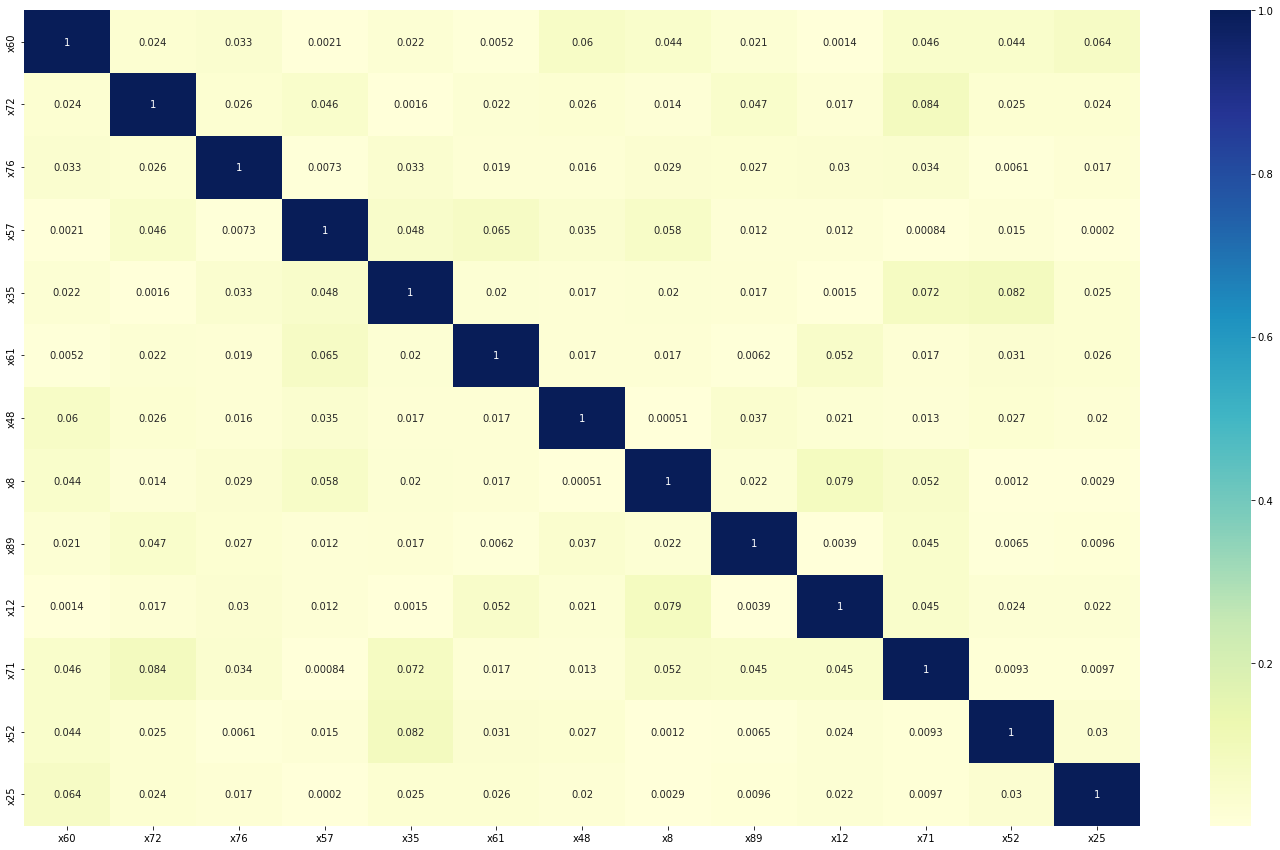

In [ ]:
plt.figure(figsize=(25,15))

sns.heatmap(np.abs(X_causal_ITE_train[ground_truth_informative_features].corr("spearman")), cmap="YlGnBu", annot=True)

<AxesSubplot:>

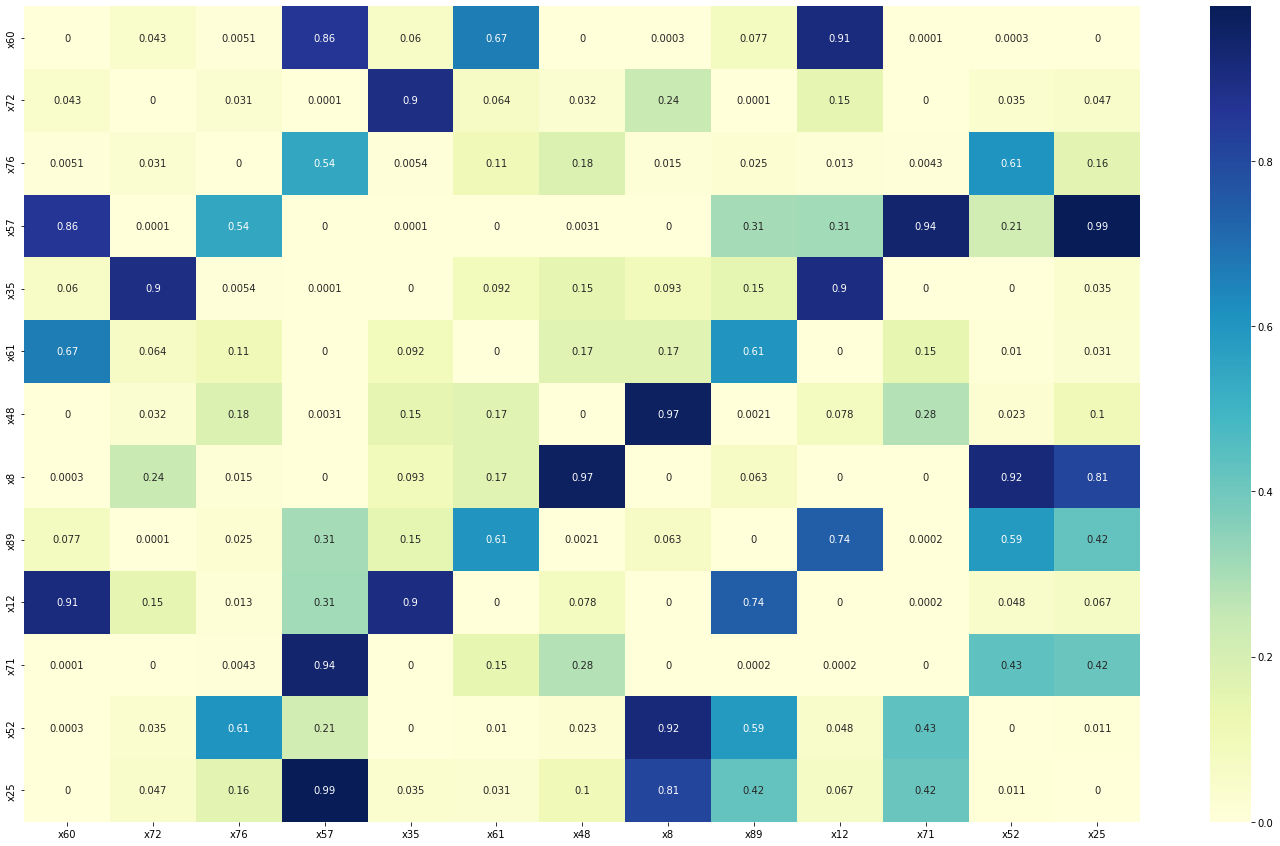

In [ ]:
plt.figure(figsize=(25,15))

# sns.heatmap(np.abs(X_causal_ITE_train[informative_features].corr("spearman")), cmap="YlGnBu", annot=True)
sns.heatmap(calculate_pvalues(X_causal_ITE_train[ground_truth_informative_features]).astype(np.float32), cmap="YlGnBu", annot=True)



In [ ]:
print(30*"=")
print("PREDICTIVE VARS FALSE POSITIVES")
print(30*"=")
for el in false_positive_predictive_features:
    second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
    second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
    print("FP feature : "+str(el))
    print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
    print(15*"-")

print("")
print(30*"=")
print("CANDIDATE VARS FALSE POSITIVES")
print(30*"=")
for el in false_positive_candidate_features:
    second_max_abs_correlation_value = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).iloc[1]
    second_max_abs_correlation_feature = np.abs(X_causal_ITE_train[ground_truth_pred_features+[el]].corr("spearman")[el]).sort_values(ascending=False).index.values[1]
    print("FP feature : "+str(el))
    print("corr value = "+str(np.round(second_max_abs_correlation_value,3))+" | feature = "+str(second_max_abs_correlation_feature))
    print(15*"-")

PREDICTIVE VARS FALSE POSITIVES

CANDIDATE VARS FALSE POSITIVES


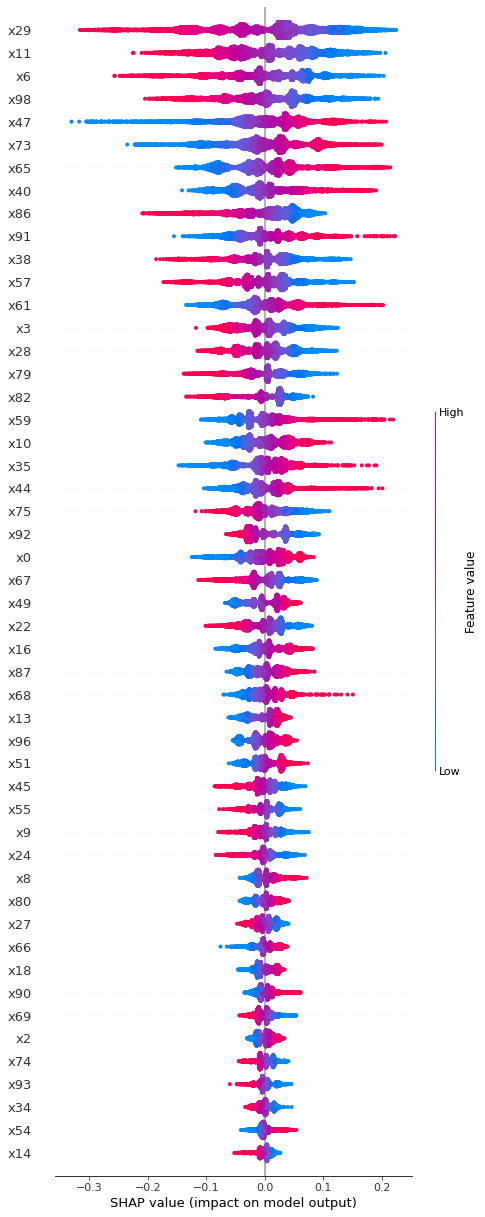

In [ ]:
if S_learner_bool:
    explainer = shap.TreeExplainer(model=predictive_CB)
else:
    explainer = shap.TreeExplainer(model=CB_T0)
shap_values_do0 = explainer.shap_values(X_causal_ITE_do0[feature_set_pred])
shap.summary_plot(shap_values_do0,X_causal_ITE_do0[feature_set_pred],max_display=50)

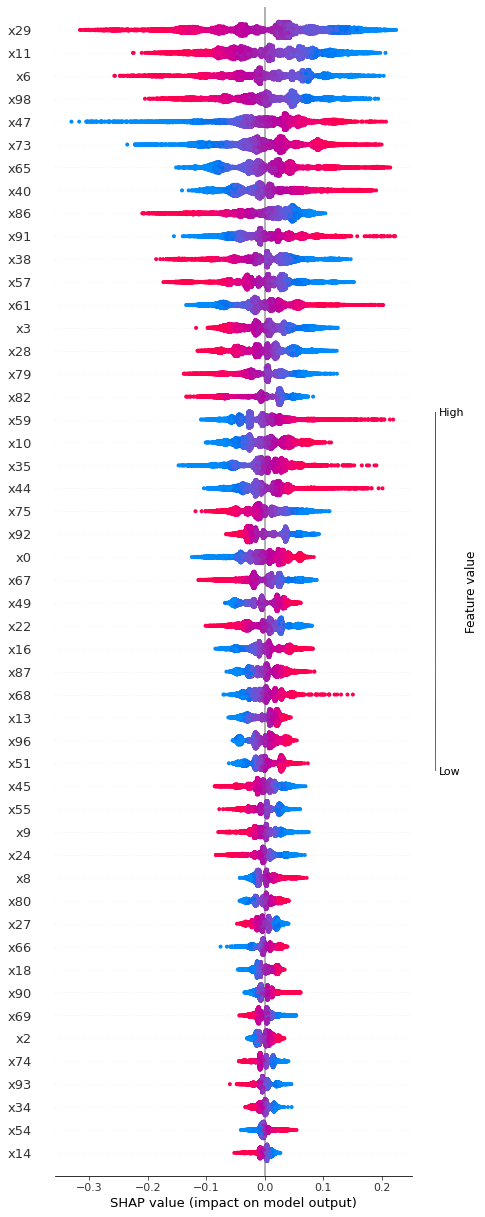

In [ ]:
if S_learner_bool:
    explainer = shap.TreeExplainer(model=predictive_CB)
else:
    explainer = shap.TreeExplainer(model=CB_T1)
shap_values_do1 = explainer.shap_values(X_causal_ITE_do1[feature_set_pred])
shap.summary_plot(shap_values_do1,X_causal_ITE_do1[feature_set_pred],max_display=50)

In [ ]:
from statsmodels.stats.weightstats import ttost_ind,ttost_paired

True predictive vars: ['x5', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x16', 'x21', 'x26', 'x28', 'x31', 'x32', 'x36', 'x37', 'x39', 'x43', 'x44', 'x46', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x57', 'x58', 'x59', 'x61', 'x65', 'x68', 'x70', 'x74', 'x77', 'x78', 'x83', 'x84', 'x87', 'x88', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x98', 'x99', 'T']
Found predictive vars: []
Found candidate vars: []


invalid value encountered in double_scalars


ValueError: arange: cannot compute length

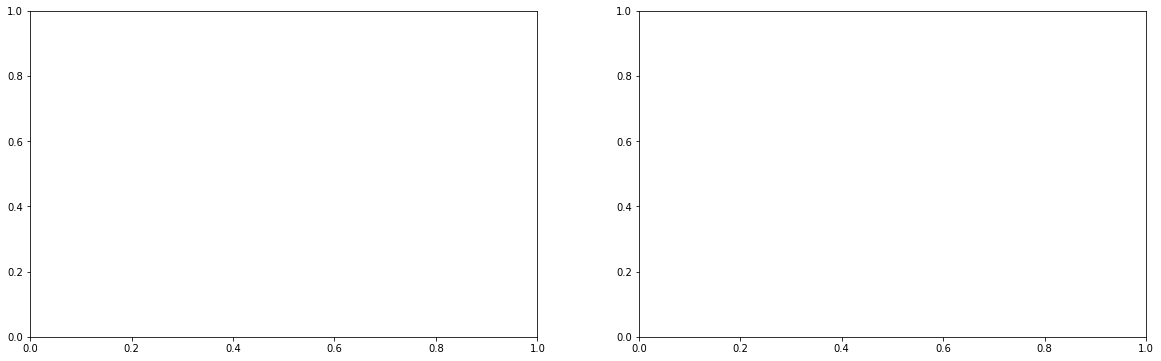

In [ ]:
plot_bins = 100#100

print("True predictive vars: " +str(ground_truth_pred_features))
print("Found predictive vars: " +str(predictive_vars))
print("Found candidate vars: " +str(candidate_vars))

for i in range(len(feature_set_pred)-2):

        p_value_is_not_greater = np.round(
                st.kstest(
                # (np.abs(pred_matrix_list[:,-1])-np.abs(prog_matrix_list[:,-1])),
                (np.abs(pred_matrix_list[:,i])-np.abs(pred_matrix_list[:,-1])),
                (np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1])),
                alternative='greater'
            )[1],3

        )

        # p_value_kstest_less = np.round(
        #         st.kstest(
        #         (np.abs(pred_matrix_list[:,i])-np.abs(pred_matrix_list[:,-1])),
        #         (np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1])),
        #         alternative='less'
        #     )[1],3
        # )

        # p_value_kstest_two_sided = np.round(
        #         st.kstest(
        #         (np.abs(pred_matrix_list[:,i])-np.abs(pred_matrix_list[:,-1])),
        #         (np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1])),
        #         alternative='two-sided'
        #     )[1],3
        # )


        # print(ttost_paired(
        #         np.abs(T1_matrix_list[:,i]),
        #         np.abs(prog_matrix_list[:,i]),
        #         np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),significance_factor/2),np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),1-significance_factor/2)
        # ))

        p_value_ttest = np.round(
                st.ttest_ind(
                np.abs(T1_matrix_list[:,i]),
                np.abs(prog_matrix_list[:,i]),
                equal_var = False,
                alternative='greater'
                )[1],3
                )
        
        
        p_value_ttest_less = np.round(
                st.ttest_ind(
                np.abs(T1_matrix_list[:,i]),
                np.abs(prog_matrix_list[:,i]),
                equal_var = False,
                alternative='less'
                )[1],3
                )
        
        p_value_ttest_two_side = np.round(
                st.ttest_ind(
                np.abs(T1_matrix_list[:,i]),
                np.abs(prog_matrix_list[:,i]),
                equal_var = False,
                alternative='two-sided'
                )[1],3
                )

        # print(np.mean(np.abs(T1_matrix_list[:,i])) - np.mean(np.abs(prog_matrix_list[:,i])))
        # print(mean_diff_random)
        # print("old")
        # print(st.ttest_ind(
        #         np.abs(T1_matrix_list[:,i]),
        #         np.abs(prog_matrix_list[:,i]),
        #         equal_var = False,
        #         alternative='two-sided'
        #         ))
        # print("new")
        # print(st.ttest_ind(
        #         np.abs(T1_matrix_list[:,i]) - mean_diff_random,
        #         np.abs(prog_matrix_list[:,i]),
        #         equal_var = False,
        #         alternative='two-sided'
        #         ))

        plot_1_max = np.max(np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]))
        plot_1_min = np.min(np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]))

        fig, axs = plt.subplots(1,2,figsize=(20,6))
        array_tested = axs[0].hist(np.abs(pred_matrix_list[:-1,i])-np.abs(pred_matrix_list[:-1,-1]),label="tested",bins=np.arange(plot_1_min,plot_1_max,(plot_1_max-plot_1_min)/plot_bins),density=True)
        array_random = axs[0].hist(np.abs(pred_matrix_list[1:,-1])-np.abs(pred_matrix_list[:-1,-1]),label="random_subtr",alpha=0.5,bins=np.arange(plot_1_min,plot_1_max,(plot_1_max-plot_1_min)/plot_bins),density=True)
        axs[0].legend()
        axs[0].set_title("Random subtr vs tested subtr (ks greater = "+str(p_value_is_not_greater)+"): "+feature_set_pred[i])
        
        # array_feature = np.append(np.append(array_tested[0],array_random[0]),[1 if feature_set_pred[i] in predictive_vars else 0])
        # hist_dataset_df = pd.concat([hist_dataset_df,pd.DataFrame([array_feature],columns=colum_features)])

        plot_2_max = np.max(np.abs(T1_matrix_list[:,i]))
        plot_2_min = np.min(np.abs(prog_matrix_list[:,i]))

        axs[1].hist(np.abs(T1_matrix_list[:,i]),label="T1",bins=np.arange(plot_2_min,plot_2_max,(plot_2_max-plot_2_min)/plot_bins))
        axs[1].hist(np.abs(prog_matrix_list[:,i]),label="T0",alpha=0.5,bins=np.arange(plot_2_min,plot_2_max,(plot_2_max-plot_2_min)/plot_bins))
        axs[1].legend()
        axs[1].set_title("T1 vs T0 (abs) (greater = "+str(p_value_ttest)+", less = "+str(p_value_ttest_less)+", two-sided = "+str(p_value_ttest_two_side)+"): " + feature_set_pred[i])

        # plot_3_max = np.quantile(T1_matrix_list[:,i],0.98)
        # plot_3_min = np.quantile(T1_matrix_list[:,i],0.02)

        # axs[2].hist(T1_matrix_list[:,i],label="T1",bins=np.arange(plot_3_min,plot_3_max,(plot_3_max-plot_3_min)/50))
        # axs[2].hist(prog_matrix_list[:,i],label="T0",alpha=0.5,bins=np.arange(plot_3_min,plot_3_max,(plot_3_max-plot_3_min)/50))
        # axs[2].legend()
        # axs[2].set_title("T1 vs T0 (ttest greater = "+str(p_value_ttest_noabs)+"): " + feature_set_pred[i])

        plt.show()

In [ ]:
np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),significance_factor/2),np.quantile(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]),1-significance_factor/2)

(-0.9307047411763351, 0.9492527797782131)

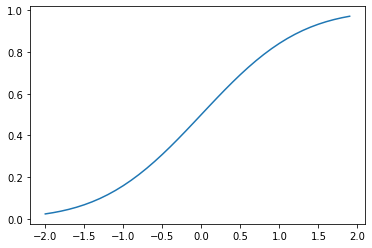

In [ ]:
plt.plot(np.arange(-2,2,0.1),st.nct.cdf(np.arange(-2,2,0.1),10000,np.mean(np.abs(T1_matrix_list[:,-1]) - np.abs(prog_matrix_list[:,-1]) )))

In [ ]:
diff_random_distr = T1_matrix_list[:,-1]-prog_matrix_list[:,-1]
diff_random_distr_normalized = (diff_random_distr - np.mean(diff_random_distr)) / np.std(diff_random_distr)


np.quantile(diff_random_distr_normalized,significance_factor/2),np.quantile(diff_random_distr_normalized,1-significance_factor/2)

(-1.9029638628694725, 1.5196783570515724)

In [ ]:
T1_normalized = (np.abs(T1_matrix_list[:,i]) - np.mean(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))/(np.std(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))
prog_normalized = (np.abs(prog_matrix_list[:,i]) - np.mean(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))/(np.std(np.abs(T1_matrix_list[:,i])-np.abs(prog_matrix_list[:,i])))

print(ttost_paired(
                T1_normalized,
                prog_normalized,
                np.quantile(diff_random_distr_normalized,significance_factor/2),np.quantile(diff_random_distr_normalized,1-significance_factor/2)
        ))

(0.0, (136.60589059486463, 0.0, 3499.0), (-65.85142515288902, 0.0, 3499.0))


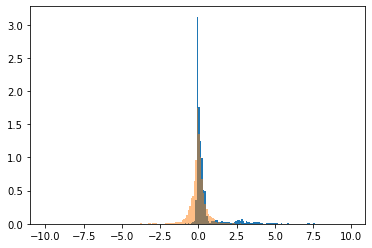

In [ ]:
plt.hist(T1_normalized - prog_normalized,bins=np.arange(-10,10,0.1),density=True)
plt.hist(diff_random_distr_normalized,bins=np.arange(-10,10,0.1),density=True,alpha=0.5)
plt.show()